<a href="https://colab.research.google.com/github/ssttv/ml-resources/blob/master/fastai_rf_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip3 install fastai==0.7.0

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import feather

In [0]:
set_plot_sizes(12,14,16)

In [0]:
PATH = '/content/drive/generic_datasets/bulldozer/'

In [0]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [0]:
m = RandomForestRegressor(n_jobs=-1)

In [0]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [0]:
train_cats(df_raw)

In [0]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [0]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
set_rf_samples(50000)


In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20603740300631812, 0.24840649042847712, 0.9112788912704799, 0.8898019646041488, 0.8942732340492705]


In [0]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.4 s, sys: 64 ms, total: 1.47 s
Wall time: 1.47 s


(9.277397367736766, 0.3684869356284048)

In [0]:

def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 109 ms, sys: 122 ms, total: 231 ms
Wall time: 1.54 s


(9.277397367736766, 0.3684869356284048)

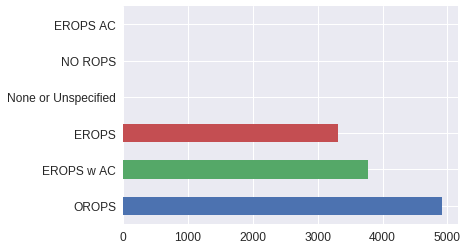

In [0]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [0]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.841499,0.278242
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.575158,0.268623
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685228,0.225130


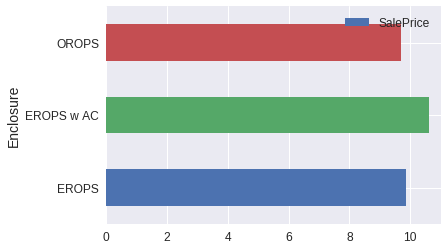

In [0]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

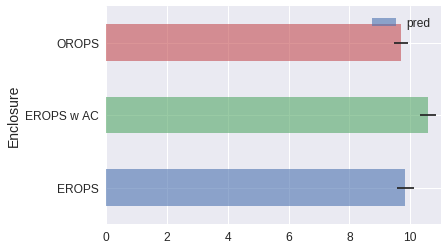

In [0]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));


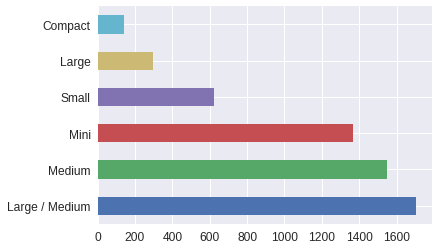

In [0]:
raw_valid.ProductSize.value_counts().plot.barh();


In [0]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.854354,0.352499
Large,10.470589,10.383514,0.368699
Large / Medium,10.691871,10.644722,0.295684
Medium,10.681511,10.619226,0.289469
Mini,9.535147,9.563096,0.258902
Small,10.324448,10.313119,0.321108


In [0]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035771
Large             0.035508
Small             0.031136
Large / Medium    0.027778
Medium            0.027259
Mini              0.027073
dtype: float64

In [0]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.178765
37,Coupler_System,0.108124
13,ProductSize,0.093223
14,fiProductClassDesc,0.072441
2,ModelID,0.057167
63,saleElapsed,0.050546
38,Grouser_Tracks,0.047352
10,fiSecondaryDesc,0.045265
39,Hydraulics_Flow,0.036175
8,fiModelDesc,0.035669


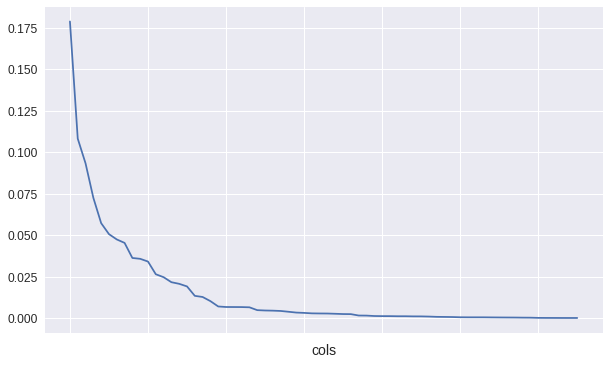

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);


In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

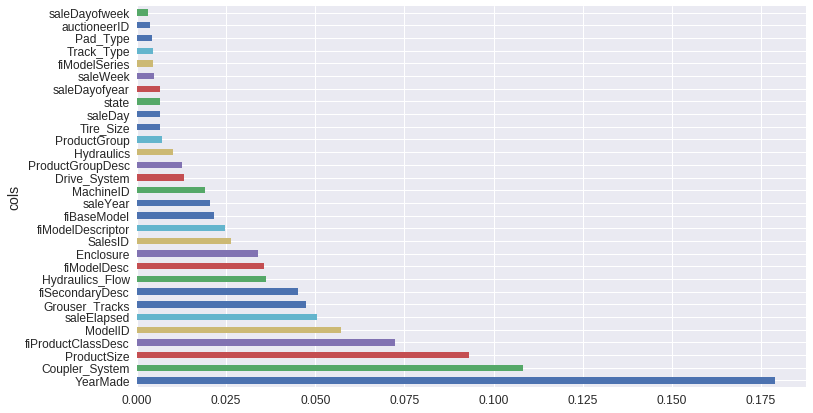

In [0]:
plot_fi(fi[:30])

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20684865132677566, 0.2458501848755171, 0.9105788577261174, 0.8920583500039477, 0.8941721710637615]


In [0]:

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

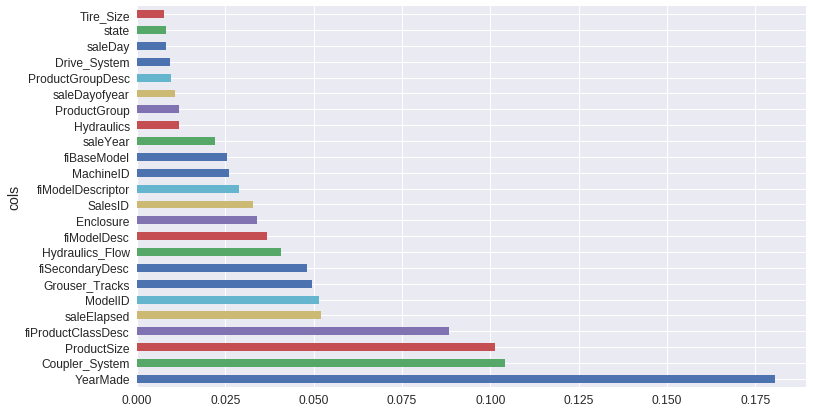

In [0]:

fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20736017336027002, 0.2548806444934826, 0.9101360466058123, 0.8839829850248935, 0.8923985509352736]
